# Wordle!


In [1]:
import matplotlib.pyplot as plt
from IPython.display import Image
from pathlib import Path
import pickle
from tqdm import tqdm
import random
import math
import os

## Modeling the Game

Here's some setup and simplifying assumptions about the game. First, we have obtained the list of 2315 words that can be chosen as the secret word. The secret word $X$ is modeled to be a random variable that has uniform distribution over these possible words. Second, your guess cannot be any arbitrary combination of 5 letters but needs to be from a list of 12972 valid guesses (which, of course, contains the 2315 possible secret words). Third, any revealed hints don't need to be used in subsequent guesses.

In [2]:
with open('data/possible_words.txt') as file:
    possible_words = [line.rstrip() for line in file]
with open('data/allowed_guesses.txt') as file:
    allowed_guesses = [line.rstrip() for line in file]

print('Number of possible_words:', len(possible_words))
print('Number of allowed_guesses:', len(allowed_guesses))

Number of possible_words: 2315
Number of allowed_guesses: 12972


`possible_words` consists of words used more frequently in the English language while `allowed_guesses` constains some words that we don't see in day-to-day life.

In [3]:
print('Some possible secret words:')
print(*random.sample(possible_words, 20), '\n')
print('Some allowed guesses:')
print(*random.sample(allowed_guesses, 20))

Some possible secret words:
wight coven pupil flare erode godly voice strip scram tiara pique shirk snort spilt diary rough bevel dunce block jaunt 

Some allowed guesses:
braai erugo krans jewed arret asana moups cloke roopy cleep mavie toads tines bevel fibro beast diode tonga oozes himbo


## Implementing the Game Logic

We then implement the logic of the game by first computing the pattern that we will see for a given pair of guess and secret word. The function `compute_pattern` takes in a guess and a secret word, and returns an integer tuple of length 5 that represents the color pattern, where an entry of 2 represents green in the corresponding position, 1 represents yellow, and 0 represents gray.

There's an edge case that we will need to consider, which is when the guess and/or the secret word contains multiple of the same letter. The rule here is that green (match in the correct spot) always has the highest priority, yellow (match in the wrong spot) prioritizes letters in earlier positions of your guess, and each letter in the secret word can only correspond to one letter in the guess. Take a look at the example below.

- If the secret word is "abide" and the guess is "three", the pattern would be (0, 0, 0, 0, 2). Position 5 is an exact match so it has the highest priority to be green. Position 4 is indeed a match in the wrong spot, but since the "e" in "abide" is already taken, it cannot match to that same "e" again.

- If the secret word is "abide" and the guess is "drama", the pattern would be (1, 0, 1, 0, 0). Position 3 is a yellow match that has priority over the potential yellow match at position 5.

In [4]:
def compute_pattern(guess, answer):
    # Returns a length 5 tuple
    
    pattern = [0, 0, 0, 0, 0]
    taken = [False, False, False, False, False]
    
    # Green pass
    for i in range(5):
        if guess[i] == answer[i]:
            # If it's an exact match, color it green, and mark it as taken
            # so that the yellow pass doesn't match to it again
            pattern[i] = 2
            taken[i] = True
    
    # Yellow pass
    for i in range(5):
        if pattern[i] == 2:
            # If a spot is already colored green, we skip it
            continue
        query = guess[i]
        for j in range(5):
            if query == answer[j] and taken[j] is False:
                # If there is a misplaced match that is not taken by the
                # green pass or a previous yellow pass, we color it yellow
                # and mark it as taken
                pattern[i] = 1
                taken[j] = True
                break
    
    return tuple(pattern)

Next, we compute the pattern between all pairs of potential guesses and potential answers, and tabulate the results for faster lookups in the future. This will take a while to run but save you a massive amount of time later. In later parts of the lab, you should use `pattern_table[guess][answer]` instead of `compute_pattern(guess, answer)`.

*Note*: Since this code block takes a long time to run, we also store the result in a file. If you don't complete the lab in one sitting, you can come back to it by loading the stored dictionary instead.

In [ ]:
load_from_file = False # can change this to true once the file has already been run

pattern_table = {}

if not load_from_file:
    for guess in tqdm(allowed_guesses):
        word_table = {}
        for answer in possible_words:
            word_table[answer] = compute_pattern(guess, answer)
        pattern_table[guess] = word_table

    if not os.path.exists('checkpoint'):
        os.mkdir('checkpoint')
    file = open('checkpoint/pattern_table', 'ab')
    pickle.dump(pattern_table, file)
    file.close()
else:
    file = open('checkpoint/pattern_table', 'rb')
    pattern_table = pickle.load(file)
    file.close()

: 

In [6]:
len(pattern_table['soare'])

2315

## Guess Strategy (from UC Berkeley's EECS126)

We use the term "alphabet of a random variable" to mean the set of potential values it could take on with positive probability (not to be confused with the English alphabet). For example, the alphabet of $X$ is the set of 2315 possible secret words.

Fix a time index $t$. Let $X_t = X|Y_1, \ldots, Y_{t-1}$ where $Y_i$ is the pattern we observe after our $i$th guess, which we assume has already happened. Then, we can see that $X_t$ also has a uniform distribution over its alphabet because the color pattens we observe only tell us which secret words are possible and which are not, but do not change the relative probabilities assigned to the possible secret words. In other words, we can think of each guess as "narrowing down" the alphabet of $X$.

Let $Y_{t,k}$ be the resulting pattern for guessing the word $k$ at timestep $t$. Both $X_t$ and $Y_{t,k}$ are random variables. Note that the index $k$ here is a word we guess. We want to minimize the conditional entropy $H(X_t|Y_{t,k})$ over $k \in$ `allowed_guesses` since it's the "leftover uncertainty" about $X_t$ after observing the color pattern for $k$. Namely, if $Y_t=Y_{t,k}$ (meaning that we guess word $k$), then $H(X_t|Y_{t,k})=\log_2 |\text{alphabet of $X_{t+1}$}|$ since $X_{t+1}$ is still uniform over its alphabet.

Recall that $$H(X_t)=I(X_t;Y_{t,k})+H(X_t|Y_{t,k}).$$

Since $H(X_t)$ is a constant given a particular observation of $Y_1, \ldots, Y_{t-1} = (y_1, \ldots, y_{t-1})$, minimizing $H(X_t|Y_{t,k})$ is equivalent to maximizing $I(X_t;Y_{t,k})$.

But what is $I(X_t;Y_{t,k})$? The mutual information is the amount of information in $X_t$ gained through observing $Y_{t,k}$, which equals the amount of information in $Y_{t,k}$ gained through observing $X_t$. However, if we know $X_t$ (which means we peek at the answer), then $Y_{t,k}|X_t$ is deterministic! Knowing $X_t$ would reduce the uncertainty in $Y_{t,k}$ from $H(Y_{t,k})$ to $0$, which means that

$$I(X_t;Y_{t,k})=H(Y_{t,k})-H(Y_{t,k}|X_t)=H(Y_{t,k})-0=H(Y_{t,k}).$$

The conclusion is that we reformulate the problem of minimizing $H(X_t|Y_{t,k})$ into maximizing $I(X_t;Y_{t,k})$ then into maximizing $H(Y_{t,k})$. Please make sure you fully understand our steps above!

**`divide_alphabet`** takes in a guess and the current alphabet. The function returns a dictionary that maps from the set of possible color patterns to the set of secret words such that `pattern_table[guess][secret_word]` is that color pattern. For example, if `guess` is "shake" and `alphabet` is {shape, shake, shame}, then the function should return the mapping (2,2,2,2,2)$\to${shake}, (2,2,2,0,2)$\to${shape, shame}.

In [7]:
def divide_alphabet(guess, alphabet):
    pattern_to_subgroup = {}
    for word in alphabet:
        pattern = pattern_table[guess][word]
        if pattern in pattern_to_subgroup:         
            pattern_to_subgroup[pattern] += [word]
        else:
            pattern_to_subgroup[pattern] = [word]
    
    return pattern_to_subgroup

Since $X$ is uniform over its alphabet, the probability that we observe each pattern is proportional to the number of words in that subgroup. **`prob_dist`** takes in the output of the above function and returns the probability distribution over the set of possible patterns. For the same example above, this function would take in the mapping (2,2,2,2,2)$\to${shake}, (2,2,2,0,2)$\to${shape, shame} and return $\left[\frac{1}{3}, \frac{2}{3}\right]$ This is the distribution of $Y_{t,k}$.

In [ ]:
def prob_dist(pattern_groups):
    # returns a probability distribution in the form of a list
    # for example, if the probability distribution is
    # P(pattern_1) = 0.2, P(pattern_2) = 0.3, P(pattern_3) = 0.5,
    # this function should return [0.2, 0.3, 0.5]. Order doesn't matter
    dist = []
    total = 0
    # TODO: your code here
    for key in pattern_groups:
        total += len(pattern_groups[key])
        dist += [len(pattern_groups[key])] 
    return [x/total for x in dist]

: 

**`entropy`** takes in a probability distribution and outputs its entropy.

In [9]:
def entropy(dist):
    # TODO: your code here
    entr = 0
    for i in range(len(dist)):
        uncertaintiy = dist[i] * math.log2(1/(dist[i]))
        entr += uncertaintiy

    return entr

**`find_best_guess`** takes in the alphabet of $X_t$ and returns the best guess to make

In [10]:
def find_best_guess(alphabet, allowed_guesses, use_tqdm=False):
    word, highest = None, 0
    if use_tqdm:
        allowed_guesses = tqdm(allowed_guesses)  # tqdm shows the progress bar
    for guess in allowed_guesses:
        divided = divide_alphabet(guess, alphabet)
        dist = prob_dist(divided)
        entr = entropy(dist)
        
        if entr > highest:
            word = guess
            highest = entr
        # TODO: your code here
        
    return word

## Best Wordle Opener

In [11]:
best_opener = find_best_guess(possible_words, allowed_guesses, use_tqdm=True)

100%|███████████████████████████████████| 12972/12972 [00:09<00:00, 1382.95it/s]


In [12]:
print('The best Wordle opener is:', best_opener)

The best Wordle opener is: soare


Expected information gain: 5.89 bits out of 11.18 bits


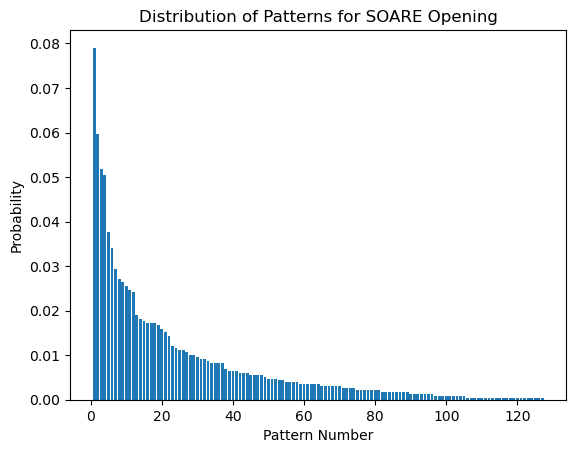

In [13]:
distribution = prob_dist(divide_alphabet('soare', possible_words))
print(f'Expected information gain: {round(entropy(distribution),2)} bits out of 11.18 bits')
distribution.sort(reverse=True)
patterns = list(range(1, len(distribution) + 1))
plt.bar(patterns, distribution)
plt.title('Distribution of Patterns for SOARE Opening')
plt.xlabel('Pattern Number')
plt.ylabel('Probability')
plt.show()

Expected information gain: 4.88 bits out of 11.18 bits


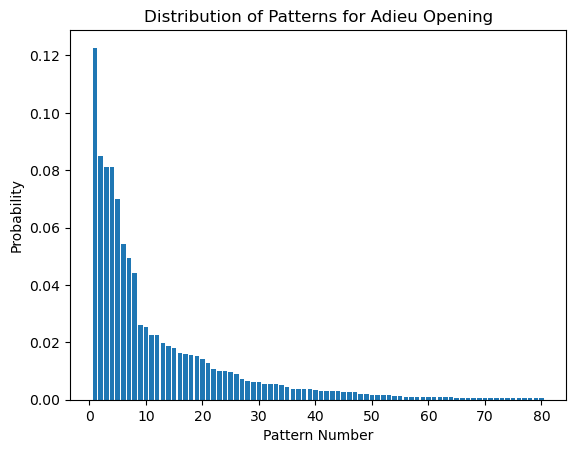

In [14]:
distribution = prob_dist(divide_alphabet('adieu', possible_words))
print(f'Expected information gain: {round(entropy(distribution),2)} bits out of 11.18 bits')
distribution.sort(reverse=True)
patterns = list(range(1, len(distribution) + 1))
plt.bar(patterns, distribution)
plt.title('Distribution of Patterns for Adieu Opening')
plt.xlabel('Pattern Number')
plt.ylabel('Probability')
plt.show()

In [13]:
def find_best_guess_optimized(alphabet):
    if len(alphabet) == 2315:
        # if it's the opening guess, we directly output 'soare'
        return 'soare'
    elif len(alphabet) == 1:
        # if we are certain what the secret word is, directly guess it
        return alphabet[0]
    elif len(alphabet) <= 3:
        # if the alphabet is small, limit our guess to within the alphabet
        return find_best_guess(alphabet, alphabet)
    else:
        # otherwise, we apply no optimization
        return find_best_guess(alphabet, allowed_guesses)

## Performance Test

In [14]:
def create_wordle_game(true_answer):
    def wordle_game(guess):
        # takes in a guess and outputs the pattern
        return pattern_table[guess][true_answer]
    
    return wordle_game

In [15]:
def play_wordle(wordle_game, print_guesses=False):
    alphabet = possible_words[:]
    num_guesses = 0
    while True:
        num_guesses += 1
        guess = find_best_guess_optimized(alphabet)
        color_pattern = wordle_game(guess)
        if print_guesses:
            print(f'Guess {num_guesses}: {guess}  |  Pattern: {color_pattern}')
        if color_pattern == (2, 2, 2, 2, 2):
            # correct answer!
            break
        # TODO: find the true pattern observed, and then update alphabet
        divided = divide_alphabet(guess, alphabet)
        alphabet = divided[color_pattern]

    return num_guesses


In [19]:
for _ in range(10):
    true_answer = random.choice(possible_words)
    print('Secret word:', true_answer)
    wordle_game = create_wordle_game(true_answer)
    play_wordle(wordle_game, print_guesses=True)
    print()

Secret word: shunt
Guess 1: soare  |  Pattern: (2, 0, 0, 0, 0)
Guess 2: thilk  |  Pattern: (1, 2, 0, 0, 0)
Guess 3: shunt  |  Pattern: (2, 2, 2, 2, 2)

Secret word: froze
Guess 1: soare  |  Pattern: (0, 1, 0, 1, 2)
Guess 2: pownd  |  Pattern: (0, 1, 0, 0, 0)
Guess 3: befit  |  Pattern: (0, 1, 1, 0, 0)
Guess 4: froze  |  Pattern: (2, 2, 2, 2, 2)

Secret word: actor
Guess 1: soare  |  Pattern: (0, 1, 1, 1, 0)
Guess 2: maron  |  Pattern: (0, 1, 1, 2, 0)
Guess 3: aback  |  Pattern: (2, 0, 0, 1, 0)
Guess 4: actor  |  Pattern: (2, 2, 2, 2, 2)

Secret word: paler
Guess 1: soare  |  Pattern: (0, 0, 1, 1, 1)
Guess 2: talar  |  Pattern: (0, 2, 2, 0, 2)
Guess 3: baler  |  Pattern: (0, 2, 2, 2, 2)
Guess 4: paler  |  Pattern: (2, 2, 2, 2, 2)

Secret word: sweep
Guess 1: soare  |  Pattern: (2, 0, 0, 0, 1)
Guess 2: clipt  |  Pattern: (0, 0, 0, 1, 0)
Guess 3: dowel  |  Pattern: (0, 0, 1, 2, 0)
Guess 4: sweep  |  Pattern: (2, 2, 2, 2, 2)

Secret word: valid
Guess 1: soare  |  Pattern: (0, 0, 1, 0, 0)
G

In [16]:
#testing today's word! (Nov, 2, 2023)
true_answer = 'total'
print('Secret word:', true_answer)
wordle_game = create_wordle_game(true_answer)
play_wordle(wordle_game, print_guesses=True)


Secret word: total
Guess 1: soare  |  Pattern: (0, 2, 1, 0, 0)
Guess 2: liman  |  Pattern: (1, 0, 0, 2, 0)
Guess 3: focal  |  Pattern: (0, 2, 0, 2, 2)
Guess 4: total  |  Pattern: (2, 2, 2, 2, 2)


4

In [31]:
num_guesses = []
num_samples = 300
for true_answer in tqdm(random.sample(possible_words, num_samples)):
    num_guesses.append(play_wordle(create_wordle_game(true_answer)))

100%|█████████████████████████████████████████| 300/300 [07:22<00:00,  1.48s/it]


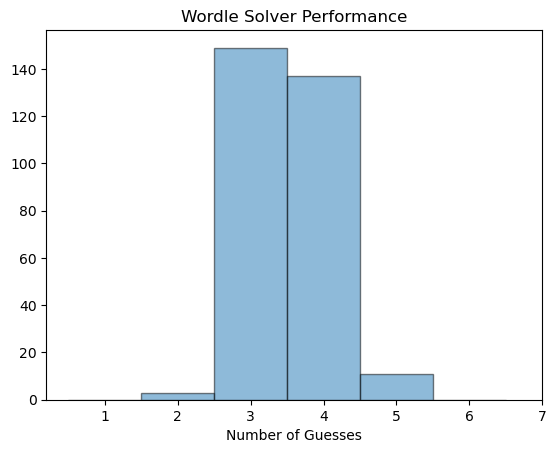

In [43]:
bins = list(range(1, 8))
plt.hist(num_guesses, bins, alpha=0.5, edgecolor='black', align='left')
plt.xlabel('Number of Guesses')
plt.xticks(list(range(1, 8)))
plt.title('Wordle Solver Performance')
plt.show()

In [44]:
print(f'Average number of Wordle guesses using entropy: {round(sum(num_guesses)/num_samples, 3)}')
print('Average number of Wordle guesses for Americans: 3.92')

Average number of Wordle guesses using entropy: 3.52
Average number of Wordle guesses for Americans: 3.92


In [37]:
class WordleBot:
    def __init__(self):
        # initialize for a new game
        self.alphabet = possible_words
        self.suggest()
    
    def suggest(self):
        # TODO: when called, the bot gives you the best word to guess
        suggested_guess = find_best_guess_optimized(self.alphabet)
        print('Next word to guess:', suggested_guess)
    
    def observe(self, word, pattern):
        # after a guess, feed the pattern to the bot to update
        # then, the bot suggests a word to guess
        assert len(word) == len(pattern) == 5
        # TODO: update self.alphabet according to the observation,
        # then call self.suggest()
        
        p_to_s = divide_alphabet(word, self.alphabet)
        self.alphabet = p_to_s[pattern]
        
        
        self.suggest()
    
    def restart(self):
        # TODO: re-initialize the bot for a new game
        self = WordleBot()
        return

In [38]:
bot = WordleBot()

Next word to guess: soare


In [39]:
bot.observe('soare', (0, 1, 0, 1, 0))

Next word to guess: cutin


In [40]:
bot.observe('cutin', (2, 0, 0, 0, 0))

Next word to guess: crock


In [41]:
bot.observe('crock', (2, 2, 2, 0, 0))

Next word to guess: crowd


In [42]:
bot.restart()

Next word to guess: soare


### Running the bot over all possible solution words and look at how well the bot does...

In [ ]:
num_guesses = []
for true_answer in tqdm(possible_words):
    num_guesses.append(play_wordle(create_wordle_game(true_answer)))


print("the distribution:", num_guesses)